In [1]:
import time
start_simulation = time.time()

import os

import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse
import scipy.special     as sp

import hylife.utilitis_FEEC.bsplines             as bsp
import hylife.utilitis_FEEC.projectors_local_mhd as mhd
import hylife.utilitis_FEEC.projectors_local     as proj
import hylife.utilitis_FEEC.derivatives          as der
import hylife.utilitis_FEEC.evaluation           as eva
import hylife.utilitis_FEEC.mass_matrices        as mass
import hylife.utilitis_FEEC.control_variate      as cv

#import hylife.utilitis_PIC.STRUPHY_fields        as pic_fields
#import hylife.utilitis_PIC.STRUPHY_pusher        as pic_pusher
#import hylife.utilitis_PIC.STRUPHY_accumulation  as pic_accumu


import hylife.utilitis_PIC_NEW.STRUPHY_fields        as pic_fields
import hylife.utilitis_PIC_NEW.STRUPHY_pusher        as pic_pusher
import hylife.utilitis_PIC_NEW.STRUPHY_accumulation  as pic_accumu


import hylife.utilitis_PIC.STRUPHY_sampling      as pic_sample
import hylife.utilitis_PIC.sobol_seq             as sobol

In [2]:
# ========================================== parameters ==============================================================
Nel       = [24, 4, 4]             # mesh generation on logical domain
bc        = [True, True, True]     # boundary conditions (True: periodic, False: else)
p         = [3, 2, 2]              # spline degrees  


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta     = [1/Nel for Nel in Nel]                                             # element sizes
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)
NbaseN    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (N functions)
NbaseD    = [NbaseN - (1 - bc) for NbaseN, bc in zip(NbaseN, bc)]              # number of basis functions (D functions)
Ntot      =  NbaseN[0]*NbaseN[1]*NbaseN[2]                                     # total number of basis functions in V0


time_int  = True     # do time integration?
dt        = 0.06     # time step
Tend      = 200.     # simulation time
max_time  = 60*60    # maximum runtime of program in minutes


# geometry (slab geometry)
kind_map  = 1
L         = [2*np.pi/0.75, 1., 1.]                                                     # box lengthes on physical domain

DF        = np.array([[  L[0], 0., 0.], [0.,   L[1], 0.], [0., 0.,   L[2]]])           # Jacobian matrix
DFinv     = np.array([[1/L[0], 0., 0.], [0., 1/L[1], 0.], [0., 0., 1/L[2]]])           # inverse Jacobian matrix

G         = np.array([[  L[0]**2, 0., 0.], [0.,   L[1]**2, 0.], [0., 0.,   L[2]**2]])  # metric tensor
Ginv      = np.array([[1/L[0]**2, 0., 0.], [0., 1/L[1]**2, 0.], [0., 0., 1/L[2]**2]])  # inverse metric tensor

g_sqrt    = L[0]*L[1]*L[2]                                                             # Jacobian determinant


# particle parameters
Np        = 1280000              # total number of particles
vth       = 1.                  # thermal velocity of particles in all directions

v0x       = 2.5                 # mean velocity of hot ions in x-direction (must be compatible with backgound field)
v0y       = 0.                  # mean velocity of hot ions in y-direction (must be compatible with backgound field)
v0z       = 0.                  # mean velocity of hot ions in z-direction (must be compatible with backgound field)

nuh       = 0.05                # ratio of hot/bulk equlibrium number densities 

control   = 0                   # control variate? (0: no, 1: yes)

# particle loading
loading   = 'sobol_antithetic'  # 'pseudo-random': particles[:, :6] = np.random.rand(Np, 6)
                                # 'sobol_standard': particles[:, :6] = sobol.i4_sobol_generate(6, Np, 1000)
                                # 'sobol_antithetic': sobol.i4_sobol_generate(6, int(Np/64), 1000) --> 64 symmetric particles
                                # 'pr_space_uni_velocity': pseudo-random in space, uniform in velocity space
                                # 'external': particles[:, :6] = np.load('name_of_file.npy')
            
        
add_pressure = False            # add pressure (non-Hamiltonian) terms to simulation?
                           
            
            
# name and directory of output data file
#identifier  = 'STRUPHY_Nel=20_p=3_L=2pidk_dt=0.04_Np=1e5_vth=1.0_v0=2.5_nuh=0.05_k=0.75_amp=1e-4_CV=on_x_sobol_ref'
identifier  = 'STRUPHY_test_NEW'
dir_results = 'results/'


# Is this run a restart? If True, locate restart files
restart = False  

name_particles = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=particles1.npy'
name_rho_coeff = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=rho_coeff1.npy'
name_u_coeff   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=u_coeff1.npy'
name_b_coeff   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=b_coeff1.npy'
name_p_coeff   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=p_coeff1.npy'
name_control   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=CV1.npy'
name_time_step = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=time1.npy'


# Create restart files at the end of the simulation? If True, name full directory where to save them
create_restart = False
dir_restart    = '/home/florian/Desktop/PHD/02_Projekte/hylife/restart_files/' + identifier + '_restart_files/'
# =====================================================================================================================



# ===================== coefficients for pp-forms in interval [0, delta] (N and D) ====================================
pp0 = []
pp1 = []

for i in range(3):
    if p[i] == 3:
        pp0.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]]))
        pp1.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]])/delta[i])
    elif p[i] == 2:
        pp0.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]]))
        pp1.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]])/delta[i])
    else:
        print('So far only cubic and quadratic splines implemented!')
# =====================================================================================================================



# ================================== background quantities for PIC ====================================================
Ueq_phys   = np.array([0., 0., 0.])     # background bulk flow (vector/1-form on physical domain)
Ueq        = DF.T.dot(Ueq_phys)         # background bulk flow (1-form on logical domain)


Beq_phys   = np.array([1., 0., 0.])     # background magnetic field (vector/2-form on physical domain)
Beq        = g_sqrt*DFinv.dot(Beq_phys) # background magnetic field (2-form on logical domain)

rhoeq_phys = 1. 
gamma      = 5/3                        # adiabatic exponent
# =====================================================================================================================


nh0_phys = rhoeq_phys*nuh                                    # hot ion number density on physical domain
nh0_123  = nh0_phys*g_sqrt                                   # hot ion number density on logical domain
Eh_eq    = nh0_123/2*(v0x**2 + v0y**2 + v0z**2 + 3*vth**2/2) # hot ion equilibrium energy

# initial hot ion distribution function (3-form on logical domain)
fh0             = lambda q1, q2, q3, vx, vy, vz : nh0_123/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)

# control variate
control_variate = lambda q1, q2, q3, vx, vy, vz : nh0_123/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)

# initial sampling distribution
g_sampling      = lambda q1, q2, q3, vx, vy, vz :       1/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)
# =====================================================================================================================

In [3]:
# ========================================= reserve memory for unknowns ===============================================
rho   = np.empty(1*Ntot, dtype=float)   # density  FEM coefficients

u     = np.empty(3*Ntot, dtype=float)   # U-field  FEM coefficients
u_old = np.empty(3*Ntot, dtype=float)   # U-field  FEM coefficients from previous time step (needed in integration step 3)

b     = np.empty(3*Ntot, dtype=float)   # B-field  FEM coefficients

pr    = np.empty(1*Ntot, dtype=float)   # pressure FEM coefficients

# matrices and vectors in steps 1 and 3
mat11 = np.empty((NbaseN[0], NbaseN[1], NbaseN[2], NbaseN[0], NbaseN[1], NbaseN[2]), dtype=float, order='F')
mat12 = np.empty((NbaseN[0], NbaseN[1], NbaseN[2], NbaseN[0], NbaseN[1], NbaseN[2]), dtype=float, order='F')
mat13 = np.empty((NbaseN[0], NbaseN[1], NbaseN[2], NbaseN[0], NbaseN[1], NbaseN[2]), dtype=float, order='F')

mat22 = np.empty((NbaseN[0], NbaseN[1], NbaseN[2], NbaseN[0], NbaseN[1], NbaseN[2]), dtype=float, order='F')
mat23 = np.empty((NbaseN[0], NbaseN[1], NbaseN[2], NbaseN[0], NbaseN[1], NbaseN[2]), dtype=float, order='F')
mat33 = np.empty((NbaseN[0], NbaseN[1], NbaseN[2], NbaseN[0], NbaseN[1], NbaseN[2]), dtype=float, order='F')

vec1  = np.empty((NbaseN[0], NbaseN[1], NbaseN[2]), dtype=float, order='F')
vec2  = np.empty((NbaseN[0], NbaseN[1], NbaseN[2]), dtype=float, order='F')
vec3  = np.empty((NbaseN[0], NbaseN[1], NbaseN[2]), dtype=float, order='F')

# particles and knot span indices
particles = np.empty((Np, 7), dtype=float, order='F')
spans0    = np.empty((Np, 3), dtype=int,   order='F')

# fields at particle positions
B_part = np.empty((Np, 3), dtype=float, order='F')
U_part = np.empty((Np, 3), dtype=float, order='F')

# energies (bulk kinetic energy, magnetic energy, bulk internal energy, hot ion kinetic + internal energy (delta f))
energies = np.empty(4, dtype=float)
# =====================================================================================================================

In [4]:
# ======================================== projection of initial conditions ===========================================
# create object for projecting initial conditions
pro = proj.projectors_local_3d(T, p, bc)

# projection of initial conditions
rho[:]              = pro.PI_3(None, 8, kind_map, L).flatten()

#temp1, temp2, temp3 = pro.PI_1([None, None, None], [2, 3, 4], kind_map, L)
temp1, temp2, temp3 = pro.PI_1([lambda xi1, xi2, xi3 : np.zeros(xi1.shape), lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1), lambda xi1, xi2, xi3 : np.zeros(xi1.shape)])

u[0*Ntot:1*Ntot]    = temp1.flatten()
u[1*Ntot:2*Ntot]    = temp2.flatten()
u[2*Ntot:3*Ntot]    = temp3.flatten()

temp1, temp2, temp3 = pro.PI_2([None, None, None], [5, 6, 7], kind_map, L)
b[0*Ntot:1*Ntot]    = temp1.flatten()
b[1*Ntot:2*Ntot]    = temp2.flatten()
b[2*Ntot:3*Ntot]    = temp3.flatten()

pr[:]               = pro.PI_0(None, 1, kind_map, L).flatten()

del temp1, temp2, temp3, pro

print('projection of initial conditions done!')
# =====================================================================================================================

projection of initial conditions done!


Text(0,0.5,'$p$')

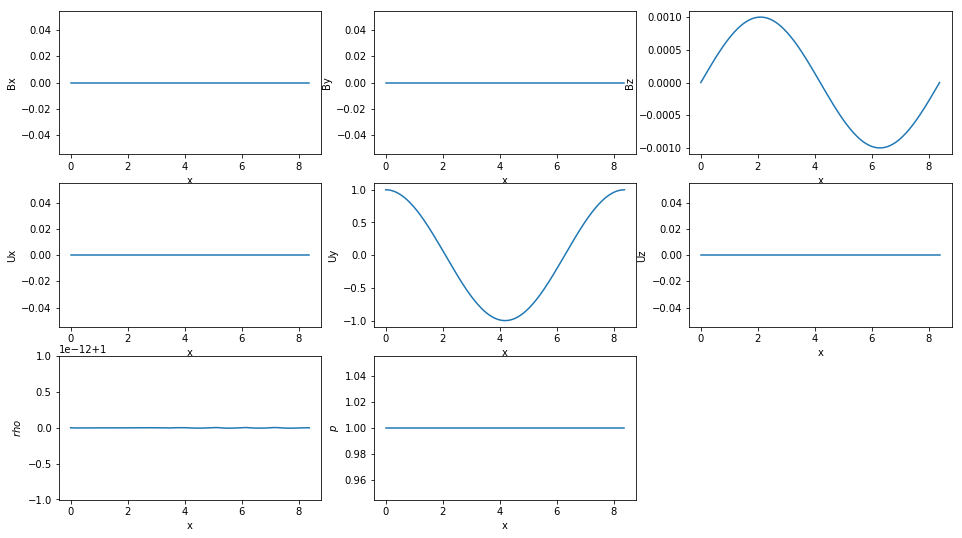

In [5]:
# plot initial conditions on physical domain
xiplot = np.linspace(0., 1., 200), np.array([0.5]), np.array([0.5])

rhoini              = eva.FEM_field_V3_3d(rho, xiplot, T, p, bc)
Bini1, Bini2, Bini3 = eva.FEM_field_V2_3d([b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot]], xiplot, T, p, bc)
Uini1, Uini2, Uini3 = eva.FEM_field_V1_3d([u[0*Ntot:1*Ntot], u[1*Ntot:2*Ntot], u[2*Ntot:3*Ntot]], xiplot, T, p, bc)
pini                = eva.FEM_field_V0_3d(pr, xiplot, T, p, bc)

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(9)

plt.subplot(3, 3, 1)
plt.plot(xiplot[0]*L[0], 1/g_sqrt*DF[0, 0]*Bini1[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Bx')

plt.subplot(3, 3, 2)
plt.plot(xiplot[0]*L[0], 1/g_sqrt*DF[1, 1]*Bini2[:, 0, 0])
plt.xlabel('x')
plt.ylabel('By')

plt.subplot(3, 3, 3)
plt.plot(xiplot[0]*L[0], 1/g_sqrt*DF[2, 2]*Bini3[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Bz')

plt.subplot(3, 3, 4)
plt.plot(xiplot[0]*L[0], DFinv[0, 0]*Uini1[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Ux')

plt.subplot(3, 3, 5)
plt.plot(xiplot[0]*L[0], DFinv[1, 1]*Uini2[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Uy')

plt.subplot(3, 3, 6)
plt.plot(xiplot[0]*L[0], DFinv[2, 2]*Uini3[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Uz')

plt.subplot(3, 3, 7)
plt.plot(xiplot[0]*L[0], rhoini[:, 0, 0]/g_sqrt)
plt.xlabel('x')
plt.ylabel('$rho$')

plt.subplot(3, 3, 8)
plt.plot(xiplot[0]*L[0], pini[:, 0, 0])
plt.xlabel('x')
plt.ylabel('$p$')

In [6]:
# ============================================ MHD matrices ===========================================================
# create object for projecting MHD matrices
MHD = mhd.projectors_local_mhd(T, p, bc)

# mass matrices in V0, V1 and V2
M0 = mass.mass_V0_3d(T, p, bc, None, kind_map, L)
M1 = mass.mass_V1_3d(T, p, bc, [None, None], kind_map, L)
M2 = mass.mass_V2_3d(T, p, bc, [None, None], kind_map, L)

# normalization vector in V0
norm = mass.inner_prod_V0_3d(T, p, bc, lambda xi1, xi2, xi3 : np.ones(xi1.shape), None, kind_map, L).flatten()

# discrete grad, curl and div matrices
derivatives = der.discrete_derivatives(T, p, bc)

GRAD = derivatives.GRAD_3d()
CURL = derivatives.CURL_3d()
DIV  = derivatives.DIV_3d()

# projection matrices
Q   = MHD.projection_Q(kind_map, L)
W   = MHD.projection_W(kind_map, L)
TAU = MHD.projection_T(kind_map, L)
S   = MHD.projection_S(kind_map, L)
K   = MHD.projection_K(kind_map, L).tocsc()

# compute matrix A
A = 1/2*(M1.dot(W) + W.T.dot(M1))

del W

# LU decompostion of Schur complement in step 2
STEP2_schur_LU = sparse.linalg.splu((A + dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc())

# other matrices needed in step 2
STEP2_1 = (A - dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc()
STEP2_2 = dt*TAU.T.dot(CURL.T.dot(M2)).tocsc()

# matrices for non-Hamiltonian part
MAT = GRAD.T.dot(M1).dot(S) + (gamma - 1)*K.T.dot(GRAD.T).dot(M1)

del S, K

LHS_LU = sparse.linalg.splu((sparse.bmat([[sparse.identity(Ntot),  dt/2*DIV.dot(Q), None], [None, A,  dt/2*M1.dot(GRAD)], [None, -dt/2*MAT, M0]])).tocsc())
RHS    =                     sparse.bmat([[sparse.identity(Ntot), -dt/2*DIV.dot(Q), None], [None, A, -dt/2*M1.dot(GRAD)], [None,  dt/2*MAT, M0]], format='csc')

A = A.toarray()

# delete everything which is not needed to save memory
del MHD, M0, GRAD, DIV, Q, MAT

print('assembly of constant matrices done!')
# ======================================================================================================================

assembly of constant matrices done!


Text(0,0.5,'$n_{h0}(U x B)_z$')

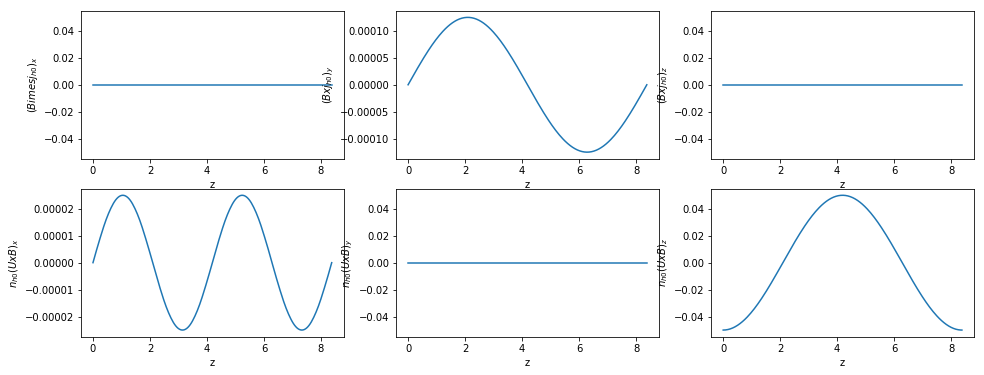

In [7]:
# check initial control variates
cont = cv.terms_control_variate(T, p, bc, kind_map, L)

J14_control = cont.inner_prod_V1_jh_eq(b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], kind_map, L)
J11_control = cont.mass_V1_nh_eq(b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], kind_map, L)

J14_control_coeff = sparse.linalg.spsolve(M1, np.concatenate((J14_control[0].flatten(), J14_control[1].flatten(), J14_control[2].flatten())))
J11_control_coeff = sparse.linalg.spsolve(M1, -J11_control.dot(u))

J14_control_1, J14_control_2, J14_control_3 = eva.FEM_field_V1_3d([J14_control_coeff[0*Ntot:1*Ntot], J14_control_coeff[1*Ntot:2*Ntot], J14_control_coeff[2*Ntot:3*Ntot]], xiplot, T, p, bc)
J11_control_1, J11_control_2, J11_control_3 = eva.FEM_field_V1_3d([J11_control_coeff[0*Ntot:1*Ntot], J11_control_coeff[1*Ntot:2*Ntot], J11_control_coeff[2*Ntot:3*Ntot]], xiplot, T, p, bc)

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)

plt.subplot(2, 3, 1)
plt.plot(xiplot[0]*L[0], DFinv[0, 0]*J14_control_1[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(B \times j_{h0})_x$')

plt.subplot(2, 3, 2)
plt.plot(xiplot[0]*L[0], DFinv[1, 1]*J14_control_2[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_y$')

plt.subplot(2, 3, 3)
plt.plot(xiplot[0]*L[0], DFinv[2, 2]*J14_control_3[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_z$')

plt.subplot(2, 3, 4)
plt.plot(xiplot[0]*L[0], DFinv[0, 0]*J11_control_1[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_x$')

plt.subplot(2, 3, 5)
plt.plot(xiplot[0]*L[0], DFinv[1, 1]*J11_control_2[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_y$')

plt.subplot(2, 3, 6)
plt.plot(xiplot[0]*L[0], DFinv[2, 2]*J11_control_3[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_z$')

In [8]:
# ================================================ create particles ====================================================
if   loading == 'pseudo-random':
    # pseudo-random numbers between (0, 1)
    particles[:, :6] = np.random.rand(Np, 6)
    
elif loading == 'sobol_standard':
    # plain sobol numbers between (0, 1) (skip first 1000 numbers)
    particles[:, :6] = sobol.i4_sobol_generate(6, Np, 1000) 
    
elif loading == 'sobol_antithetic':
    # symmetric sobol numbers between (0, 1) (skip first 1000 numbers) in all 6 dimensions
    pic_sample.set_particles_symmetric(sobol.i4_sobol_generate(6, int(Np/64), 1000), particles)  
    
elif loading == 'pr_space_uni_velocity':
    # pseudo-random numbers in space and uniform in velocity space
    particles[:, :3] = np.random.rand(Np, 3)
    
    dv = 1/Np
    particles[:,  3] = np.linspace(dv, 1 - dv, Np)
    particles[:,  4] = np.linspace(dv, 1 - dv, Np)
    particles[:,  5] = np.linspace(dv, 1 - dv, Np)
    
elif loading == 'external':
    # load numbers between (0, 1) from an external file
    particles[:, :6] = np.load('test_particles.npy')
    
else:
    print('particle loading not specified')

# inversion of cumulative distribution function
particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*vth + v0x
particles[:, 4]  = sp.erfinv(2*particles[:, 4] - 1)*vth + v0y
particles[:, 5]  = sp.erfinv(2*particles[:, 5] - 1)*vth + v0z

# compute parameters for control variate and initial weights
g0 = g_sampling(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0

particles[:, 6] = w0 - control*control_variate(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0 

print('particle initialization done!')
# =====================================================================================================================

particle initialization done!


In [9]:
# ================ compute initial fields at particle positions and initial energies ==================================
Nbase_1form = np.asfortranarray([[NbaseD[0], NbaseN[1], NbaseN[2]], [NbaseN[0], NbaseD[1], NbaseN[2]], [NbaseN[0], NbaseN[1], NbaseD[2]]])
Nbase_2form = np.asfortranarray([[NbaseN[0], NbaseD[1], NbaseD[2]], [NbaseD[0], NbaseN[1], NbaseD[2]], [NbaseD[0], NbaseD[1], NbaseN[2]]])

timea = time.time()
pic_fields.evaluate_2form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, Nbase_2form, Np, np.asfortranarray(b[:Ntot].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), np.asfortranarray(b[2*Ntot:].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part, kind_map, L)
pic_fields.evaluate_1form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, Nbase_1form, Np, np.asfortranarray(u[:Ntot].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), np.asfortranarray(u[Ntot:2*Ntot].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), np.asfortranarray(u[2*Ntot:].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part, kind_map, L)
timeb = time.time()
print('initial field computation at particles done. Time : ', timeb-timea)


# initial energies
energies[0] = 1/2*u.dot(A.dot(u))
energies[1] = 1/2*b.dot(M2.dot(b))
energies[2] = 1/(gamma - 1)*pr.dot(norm)
energies[3] = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)/Np + (control - 1)*Eh_eq
# =====================================================================================================================

initial field computation at particles done. Time :  7.318842887878418


In [10]:
acc = pic_accumu.accumulation(T, p, bc)

In [11]:
R, J14_control = acc.accumulation_step3(particles, B_part, kind_map, L)
#J11_control = acc.accumulation_step1(particles, B_part, kind_map, L)

"\nplt.subplot(2, 3, 4)\nplt.plot(xiplot[0]*L[0], DFinv[0, 0]*J11_control_1[:, 0, 0])\nplt.xlabel('z')\nplt.ylabel('$n_{h0}(U x B)_x$')\n\nplt.subplot(2, 3, 5)\nplt.plot(xiplot[0]*L[0], DFinv[1, 1]*J11_control_2[:, 0, 0])\nplt.xlabel('z')\nplt.ylabel('$n_{h0}(U x B)_y$')\n\nplt.subplot(2, 3, 6)\nplt.plot(xiplot[0]*L[0], DFinv[2, 2]*J11_control_3[:, 0, 0])\nplt.xlabel('z')\nplt.ylabel('$n_{h0}(U x B)_z$')\n"

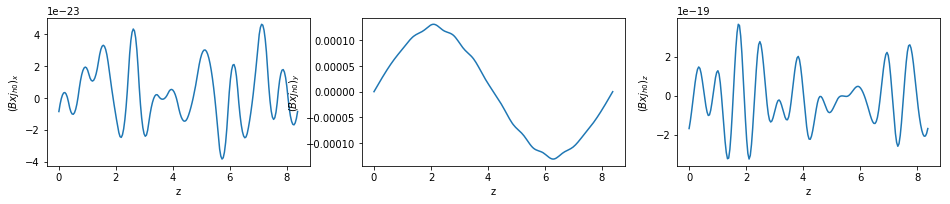

In [13]:
# check initial accumulation terms
J14_control_coeff = sparse.linalg.spsolve(M1, J14_control/Np)
#J11_control_coeff = sparse.linalg.spsolve(M1, -J11_control.dot(u)/Np)

J14_control_1, J14_control_2, J14_control_3 = eva.FEM_field_V1_3d([J14_control_coeff[0*Ntot:1*Ntot], J14_control_coeff[1*Ntot:2*Ntot], J14_control_coeff[2*Ntot:3*Ntot]], xiplot, T, p, bc)
#J11_control_1, J11_control_2, J11_control_3 = eva.FEM_field_V1_3d([J11_control_coeff[0*Ntot:1*Ntot], J11_control_coeff[1*Ntot:2*Ntot], J11_control_coeff[2*Ntot:3*Ntot]], xiplot, T, p, bc)

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)


plt.subplot(2, 3, 1)
plt.plot(xiplot[0]*L[0], DFinv[0, 0]*J14_control_1[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_x$')

plt.subplot(2, 3, 2)
plt.plot(xiplot[0]*L[0], DFinv[1, 1]*J14_control_2[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_y$')

plt.subplot(2, 3, 3)
plt.plot(xiplot[0]*L[0], DFinv[2, 2]*J14_control_3[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_z$')

'''
plt.subplot(2, 3, 4)
plt.plot(xiplot[0]*L[0], DFinv[0, 0]*J11_control_1[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_x$')

plt.subplot(2, 3, 5)
plt.plot(xiplot[0]*L[0], DFinv[1, 1]*J11_control_2[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_y$')

plt.subplot(2, 3, 6)
plt.plot(xiplot[0]*L[0], DFinv[2, 2]*J11_control_3[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_z$')
'''

In [10]:
# =============================================== time integrator =====================================================
def update():
    
    # step 1 (update u)
    pic_accumu.accumulation_step1(particles, p, spans0, NbaseN, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat12, mat13, mat23)
    
    AJ11A = -np.block([[np.zeros((Ntot, Ntot)), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [-mat12.reshape(Ntot, Ntot).T, np.zeros((Ntot, Ntot)), mat23.reshape(Ntot, Ntot)], [-mat13.reshape(Ntot, Ntot).T, -mat23.reshape(Ntot, Ntot).T, np.zeros((Ntot, Ntot))]])/Np
    
    if control == 1:
        AJ11A -= cont.mass_V1_nh_eq(b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], kind_map, L).toarray()
    
    u[:] = np.linalg.solve(A - dt/2*AJ11A, (A + dt/2*AJ11A).dot(u))
    
    
    # step 2 (update first u, then b and evaluate B-field at particle positions)
    u_old[:] = u
    
    u[:] = STEP2_schur_LU.solve(STEP2_1.dot(u_old) + STEP2_2.dot(b))
    b[:] = b - dt/2*CURL.dot(TAU.dot(u_old + u))
    
    pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, NbaseN, Np, np.asfortranarray(b[:Ntot].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), np.asfortranarray(b[2*Ntot:].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
    
    
    # step 3 (update first u, then evaluate U-field at particle positions and then update V)
    pic_accumu.accumulation_step3(particles, p, spans0, NbaseN, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat11, mat12, mat13, mat22, mat23, mat33, vec1, vec2, vec3)
    
    BLOCK = np.block([[mat11.reshape(Ntot, Ntot), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [mat12.reshape(Ntot, Ntot).T, mat22.reshape(Ntot, Ntot), mat23.reshape(Ntot, Ntot)], [mat13.reshape(Ntot, Ntot).T, mat23.reshape(Ntot, Ntot).T, mat33.reshape(Ntot, Ntot)]])/Np
    
    u_old[:] = u
    
    if control == 1:
        CV = cont.inner_prod_V1_jh_eq(b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], kind_map, L)
        
        u[:] = np.linalg.solve(A + dt**2/4*BLOCK, (A - dt**2/4*BLOCK).dot(u_old) + dt*np.concatenate((vec1.flatten(), vec2.flatten(), vec3.flatten()))/Np + dt*np.concatenate((CV[0].flatten(), CV[1].flatten(), CV[2].flatten())))
    
    
    else:
        u[:] = np.linalg.solve(A + dt**2/4*BLOCK, (A - dt**2/4*BLOCK).dot(u_old) + dt*np.concatenate((vec1.flatten(), vec2.flatten(), vec3.flatten()))/Np)
    
    
    pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, NbaseN, Np, np.asfortranarray(1/2*(u + u_old)[:Ntot].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), np.asfortranarray(1/2*(u + u_old)[Ntot:2*Ntot].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), np.asfortranarray(1/2*(u + u_old)[2*Ntot:].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)
    
    pic_pusher.pusher_step3(particles, L, dt, B_part, U_part)
    
    # step 4 (update Q and span indices)
    pic_pusher.pusher_step4(particles, L, dt)
    
    spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
    spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
    spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]
    
    # step 5 (update V and weights)
    pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, NbaseN, Np, np.asfortranarray(b[:Ntot].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), np.asfortranarray(b[2*Ntot:].reshape(NbaseN[0], NbaseN[1], NbaseN[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
    pic_pusher.pusher_step5(particles, L, dt, B_part)
    
    particles[:, 6] = w0 - control*control_variate(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0 
    
    # step 6 (non-Hamiltonian)
    if add_pressure:
        rho[:], u[:], pr[:] = np.split(LHS_LU.solve(RHS.dot(np.concatenate((rho, u, pr)))), [Ntot, 4*Ntot])
    
    # diagnostics (compute energies)
    energies[0] = 1/2*u.dot(A.dot(u))
    energies[1] = 1/2*b.dot(M2.dot(b))
    energies[2] = 1/(gamma - 1)*pr.dot(norm)
    energies[3] = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)/Np + (control - 1)*Eh_eq
# =====================================================================================================================    

In [11]:
# ========================================== time integration =========================================================
if time_int == True:
    
    if restart == False:
        title = dir_results + identifier + '.txt'
        file  = open(title, 'ab')
        
        
        # == initial data to save ==
        data  = np.concatenate((energies, np.array([0.])))
        np.savetxt(file, data.reshape(1, 5), fmt = '%1.16e')
        
        #data  = np.concatenate((pr, u[1*Ntot:2*Ntot], u[2*Ntot:3*Ntot], energies, np.array([0.])))
        #np.savetxt(file, data.reshape(1, len(pr) + len(u[1*Ntot:2*Ntot]) + len(u[2*Ntot:3*Ntot]) + 5), fmt = '%1.16e')
        # ==========================

        print('initial energies : ', energies)
        
        time_step = 0
        counter   = 0
        
    else:
        title = dir_results + identifier + '.txt'
        file  = open(title, 'ab')
        
        particles[:, :]    = np.load(name_particles)
        rho[:]             = np.load(name_rho_coeff)
        u[:]               = np.load(name_u_coeff)
        b[:]               = np.load(name_b_coeff)
        pr[:]              = np.load(name_p_coeff)
        w0                 = np.load(name_control)[0]
        g0                 = np.load(name_control)[1]
        time_step, counter = np.load(name_time_step)
        
        spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
        spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
        spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]
        
        pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
        pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(u[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)
        
        particles[:, 6] = w0 - control*control_variate(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0 

        
    print('start time integration! (total number of time steps : ' + str(int(Tend/dt)) + ')')
    
    while True:

        if (time_step*dt >= Tend) or ((time.time() - start_simulation)/60 > max_time):
            
            if create_restart:
                
                if not os.path.exists(dir_restart):
                    os.makedirs(dir_restart)
                
                counter += 1

                np.save(dir_restart + identifier + '_restart=particles' + str(counter), particles)
                np.save(dir_restart + identifier + '_restart=rho_coeff' + str(counter), rho)
                np.save(dir_restart + identifier + '_restart=u_coeff'   + str(counter), u)
                np.save(dir_restart + identifier + '_restart=b_coeff'   + str(counter), b)
                np.save(dir_restart + identifier + '_restart=p_coeff'   + str(counter), pr)
                np.save(dir_restart + identifier + '_restart=CV'        + str(counter), np.vstack((w0, g0)))
                np.save(dir_restart + identifier + '_restart=time'      + str(counter), np.array([time_step, counter]))
            
            break

        if time_step%10 == 0:
            print('time steps finished : ' + str(time_step))
            print('energies : ', energies)

        timea = time.time()
        update()
        timeb = time.time()

        if time_step == 0:
            print('time for one time step : ', timeb-timea)

        # == data to save ==========
        data  = np.concatenate((energies, np.array([(time_step + 1)*dt])))
        np.savetxt(file, data.reshape(1, 5), fmt = '%1.16e')
        
        #data  = np.concatenate((pr, u[1*Ntot:2*Ntot], u[2*Ntot:3*Ntot], energies, np.array([(time_step + 1)*dt])))
        #np.savetxt(file, data.reshape(1, len(pr) + len(u[1*Ntot:2*Ntot]) + len(u[2*Ntot:3*Ntot]) + 5), fmt = '%1.16e')
        # ==========================

        time_step += 1

    file.close()
# =====================================================================================================================

initial energies :  [0.00000000e+00 2.09356489e-06 1.25663706e+01 0.00000000e+00]
start time integration! (total number of time steps : 3333)
time steps finished : 0
energies :  [0.00000000e+00 2.09356489e-06 1.25663706e+01 0.00000000e+00]
time for one time step :  9.341720342636108
time steps finished : 10
energies :  [ 4.12613335e-07  1.69700129e-06  1.25663706e+01 -1.00001370e-08]
time steps finished : 20
energies :  [ 1.38538574e-06  8.02146203e-07  1.25663706e+01 -8.27038171e-08]
time steps finished : 30
energies :  [ 2.17157691e-06  1.10605833e-07  1.25663706e+01 -1.85007644e-07]
time steps finished : 40
energies :  [ 2.10592502e-06  1.99040806e-07  1.25663706e+01 -2.10049040e-07]
time steps finished : 50
energies :  [ 1.26829366e-06  1.00898248e-06  1.25663706e+01 -1.77774007e-07]
time steps finished : 60
energies :  [ 3.67253803e-07  1.89295598e-06  1.25663706e+01 -1.76194106e-07]
time steps finished : 70
energies :  [ 1.86297099e-07  2.14650916e-06  1.25663706e+01 -2.33611078e

KeyboardInterrupt: 